**Occlusion‑Aware Object Detection (BDD100K)**


Baselines: YOLOv5s, RT‑DETR, DETR (ResNet‑50)
Proposed model: OcaDETR (DETR + Occlusion Attention Module + Region‑aware occlusion loss)
Main claim (for your report): OcaDETR improves metrics on high‑occlusion objects (e.g., occlusion_ratio ≥ 0.6).



COCO-style dict (det_train.json, det_val.json)
BDD list format (bdd100k_labels_images_train.json, etc.)


## 0) Install dependencies


In [1]:
!pip -q install ultralytics transformers pycocotools opencv-python-headless captum tqdm pandas pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00


## 1) Imports, seed, and paths


In [2]:
import os, json, random, math
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Sequence

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

INPUT = Path("/kaggle/input")
WORK  = Path("/kaggle/working")
WORK.mkdir(parents=True, exist_ok=True)

print("Inputs:")
for p in sorted(INPUT.iterdir()):
    if p.is_dir():
        print(" -", p.name)


DEVICE: cuda
Inputs:
 - bdd100k
 - bdd100k-labels


## 2) Locate BDD100K images + labels


In [3]:
BDD_IMG_DS   = Path("/kaggle/input/bdd100k")
BDD_LABEL_DS = Path("/kaggle/input/bdd100k-labels")

bdd_train_imgs = BDD_IMG_DS / "train"
bdd_val_imgs   = BDD_IMG_DS / "val"

assert bdd_train_imgs.exists(), f"Missing: {bdd_train_imgs}"
assert bdd_val_imgs.exists(),   f"Missing: {bdd_val_imgs}"

def find_first_file(root: Path, patterns: List[str]) -> Optional[Path]:
    for pat in patterns:
        hits = list(root.rglob(pat))
        if hits:
            hits = sorted(hits, key=lambda p: len(str(p)))
            return hits[0]
    return None

train_label_patterns = ["det_train.json", "*det_train.json", "*labels_images_train*.json", "*bdd100k_labels_images_train*.json"]
val_label_patterns   = ["det_val.json",   "*det_val.json",   "*labels_images_val*.json",   "*bdd100k_labels_images_val*.json"]

bdd_train_label = find_first_file(BDD_LABEL_DS, train_label_patterns) or find_first_file(BDD_IMG_DS, train_label_patterns)
bdd_val_label   = find_first_file(BDD_LABEL_DS, val_label_patterns)   or find_first_file(BDD_IMG_DS, val_label_patterns)

print("Train images:", bdd_train_imgs)
print("Val images  :", bdd_val_imgs)
print("Train labels:", bdd_train_label)
print("Val labels  :", bdd_val_label)

assert bdd_train_label and bdd_train_label.exists(), "Train label JSON not found"
assert bdd_val_label and bdd_val_label.exists(),     "Val label JSON not found"


Train images: /kaggle/input/bdd100k/train
Val images  : /kaggle/input/bdd100k/val
Train labels: /kaggle/input/bdd100k/train/annotations/bdd100k_labels_images_train.json
Val labels  : /kaggle/input/bdd100k/val/annotations/bdd100k_labels_images_val.json


## 3) Convert BDD labels to COCO subset (supports both JSON formats)


In [4]:
# Choose your detection classes (BDD100K det subset)
BDD_CLASSES = [
    "person","rider","car","truck","bus","train",
    "motorcycle","bicycle","traffic light","traffic sign"
]

# Kaggle-friendly subset sizes (increase later if you want)
MAX_TRAIN = 2000
MAX_VAL   = 500

def load_json(path: Path):
    return json.loads(path.read_text(encoding="utf-8"))

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

def img_size_fast(img_path: Path) -> Tuple[int,int]:
    with Image.open(img_path) as im:
        return im.size  # (W,H)

def _resolve_image(images_dir: Path, file_name: str) -> Optional[Path]:
    p = images_dir / file_name
    if p.exists():
        return p
    hits = list(images_dir.rglob(file_name))
    return hits[0] if hits else None

def bdd_to_coco(bdd_json: Path, images_dir: Path, out_json: Path,
                classes: List[str], max_images: int):
    '''
    Robust converter for BDD100K label JSON -> COCO.

    Supports BOTH common formats:
    1) COCO-style dict: {"images":..., "annotations":..., "categories":...}
       (e.g., det_train.json / det_val.json in some distributions)
    2) BDD "labels_images_*.json" list format:
       [{"name": "...jpg", "labels": [{"category": "...", "box2d": {...}, "attributes": {...}}, ...]}, ...]

    Output COCO uses:
    - category ids: 1..K in the order of `classes`
    - image ids: 1..N contiguous
    - occlusion_ratio: preserved if present, else approximated from attributes.occluded/occlusion
    '''
    raw = load_json(bdd_json)
    keep = set(classes)

    # Stable categories (1..K)
    categories = [{"id": i+1, "name": c, "supercategory": "object"} for i,c in enumerate(classes)]
    name_to_catid = {c["name"]: c["id"] for c in categories}

    images = []
    annotations = []
    ann_id = 1
    img_id = 1

    # --- Format A: COCO-like dict
    if isinstance(raw, dict) and "images" in raw and "annotations" in raw and "categories" in raw:
        orig_id_to_name = {int(c["id"]): c["name"] for c in raw.get("categories", [])}

        anns_by_img = {}
        for a in raw["annotations"]:
            cat_name = orig_id_to_name.get(int(a["category_id"]), None)
            if cat_name is None or cat_name not in keep:
                continue
            anns_by_img.setdefault(int(a["image_id"]), []).append(a)

        for im in raw["images"]:
            old_img_id = int(im["id"])
            if old_img_id not in anns_by_img:
                continue

            fn = im.get("file_name") or im.get("name")
            if not fn:
                continue
            p = _resolve_image(images_dir, fn)
            if not p:
                continue

            if len(images) >= max_images:
                break

            W = int(im.get("width") or img_size_fast(p)[0])
            H = int(im.get("height") or img_size_fast(p)[1])

            images.append({"id": img_id, "file_name": fn, "width": W, "height": H})

            for a in anns_by_img[old_img_id]:
                cat_name = orig_id_to_name[int(a["category_id"])]
                x,y,w,h = a["bbox"]
                area = float(a.get("area", w*h))
                occ = float(a.get("occlusion_ratio", a.get("occ", 0.0)))
                annotations.append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": int(name_to_catid[cat_name]),
                    "bbox": [float(x), float(y), float(w), float(h)],
                    "area": area,
                    "iscrowd": int(a.get("iscrowd", 0)),
                    "occlusion_ratio": float(np.clip(occ, 0.0, 1.0)),
                })
                ann_id += 1

            img_id += 1

    # --- Format B: BDD list format
    elif isinstance(raw, list):
        for item in raw:
            if len(images) >= max_images:
                break

            fn = item.get("name") or item.get("file_name")
            if not fn:
                continue
            p = _resolve_image(images_dir, fn)
            if not p:
                continue

            labels = item.get("labels") or []
            if not isinstance(labels, list) or len(labels) == 0:
                continue

            W,H = img_size_fast(p)

            anns_this = []
            for lab in labels:
                cat = lab.get("category") or lab.get("label")
                if cat not in keep:
                    continue
                box = lab.get("box2d")
                if not box:
                    continue

                x1 = float(box.get("x1", 0.0)); y1 = float(box.get("y1", 0.0))
                x2 = float(box.get("x2", 0.0)); y2 = float(box.get("y2", 0.0))
                x = float(min(x1,x2)); y = float(min(y1,y2))
                w = float(abs(x2-x1)); h = float(abs(y2-y1))
                if w < 1.0 or h < 1.0:
                    continue

                attrs = lab.get("attributes") or {}
                occ_ratio = 0.0
                if "occluded" in attrs:
                    occ_ratio = 1.0 if bool(attrs["occluded"]) else 0.0
                elif "occlusion" in attrs:
                    val = str(attrs["occlusion"]).lower()
                    if val in ("none","0","no"):
                        occ_ratio = 0.0
                    elif val in ("partial","1","medium"):
                        occ_ratio = 0.5
                    elif val in ("heavy","2","full","yes","true"):
                        occ_ratio = 0.9
                    else:
                        occ_ratio = 0.0

                anns_this.append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": int(name_to_catid[cat]),
                    "bbox": [x,y,w,h],
                    "area": float(w*h),
                    "iscrowd": 0,
                    "occlusion_ratio": float(np.clip(occ_ratio, 0.0, 1.0)),
                })
                ann_id += 1

            if len(anns_this) == 0:
                continue

            images.append({"id": img_id, "file_name": fn, "width": int(W), "height": int(H)})
            annotations.extend(anns_this)
            img_id += 1

    else:
        raise ValueError("Unsupported label JSON structure. Expected COCO dict or BDD labels_images list.")

    out = {"info": {"description": "BDD100K -> COCO subset", "version": "1.0"}, "licenses": [], "images": images, "annotations": annotations, "categories": categories}
    save_json(out, out_json)
    print(f"[OK] Wrote COCO: {out_json}  images={len(images)}  anns={len(annotations)}  cats={len(categories)}")
    return out_json

bdd_coco_train = WORK / "data/bdd_coco_train.json"
bdd_coco_val   = WORK / "data/bdd_coco_val.json"

bdd_to_coco(bdd_train_label, bdd_train_imgs, bdd_coco_train, BDD_CLASSES, MAX_TRAIN)
bdd_to_coco(bdd_val_label,   bdd_val_imgs,   bdd_coco_val,   BDD_CLASSES, MAX_VAL)


[OK] Wrote COCO: /kaggle/working/data/bdd_coco_train.json  images=2000  anns=36060  cats=10
[OK] Wrote COCO: /kaggle/working/data/bdd_coco_val.json  images=500  anns=9275  cats=10


PosixPath('/kaggle/working/data/bdd_coco_val.json')

## 4) Optional: Synthetic occlusion augmentation (clean + low label noise)


In [5]:
import cv2

AUG_ENABLE = True
AUG_MAX_IMAGES = 400  # Kaggle-friendly

aug_root = WORK / "data/bdd_occ_aug"
aug_img_dir = aug_root / "images"
aug_img_dir.mkdir(parents=True, exist_ok=True)

def add_synthetic_occlusions(coco_in: Path, images_dir: Path, coco_out: Path):
    '''
    Creates synthetic occluded copies of some training images.

    Clean fix:
    - Only the chosen object is labeled as occluded / increased occlusion_ratio.
    - Other objects keep their original occlusion_ratio.
    '''
    coco = load_json(coco_in)
    new_images = list(coco["images"])
    new_anns   = list(coco["annotations"])

    next_img_id = max(im["id"] for im in new_images) + 1
    next_ann_id = max(an["id"] for an in new_anns) + 1

    anns_by_img = {}
    for a in coco["annotations"]:
        anns_by_img.setdefault(a["image_id"], []).append(a)

    made = 0
    for im in tqdm(coco["images"], desc="Synthetic occlusion"):
        if made >= AUG_MAX_IMAGES:
            break
        anns = anns_by_img.get(im["id"], [])
        if not anns:
            continue

        src_path = images_dir / im["file_name"]
        if not src_path.exists():
            hits = list(images_dir.rglob(im["file_name"]))
            if not hits:
                continue
            src_path = hits[0]

        img_bgr = cv2.imread(str(src_path))
        if img_bgr is None:
            continue

        chosen = random.choice(anns)
        sev = random.choice([0.2, 0.4, 0.6, 0.8])

        x,y,w,h = chosen["bbox"]
        x=int(max(0,x)); y=int(max(0,y)); w=int(max(1,w)); h=int(max(1,h))

        target_area = max(1, int(sev*w*h))
        rw = max(1, int(math.sqrt(target_area)))
        rh = max(1, int(target_area / rw))
        rw=min(rw,w); rh=min(rh,h)
        rx = x + random.randint(0, max(0, w-rw))
        ry = y + random.randint(0, max(0, h-rh))
        img_bgr[ry:ry+rh, rx:rx+rw] = (40,40,40)

        new_name = f"occ_{im['id']}_{im['file_name']}"
        out_path = aug_img_dir / new_name
        cv2.imwrite(str(out_path), img_bgr)

        new_images.append({
            "id": next_img_id,
            "file_name": new_name,
            "width": im["width"],
            "height": im["height"],
            "source_image_id": im["id"],
            "synthetic_occlusion_severity": float(sev),
            "synthetic_occluded_ann_id": int(chosen["id"]),
        })

        chosen_id = int(chosen["id"])
        for an in anns:
            an2 = dict(an)
            an2["id"] = next_ann_id; next_ann_id += 1
            an2["image_id"] = next_img_id

            if int(an["id"]) == chosen_id:
                base_occ = float(an.get("occlusion_ratio", 0.0))
                an2["occlusion_ratio"] = float(max(base_occ, sev))
                an2["occluded"] = True
            else:
                an2["occlusion_ratio"] = float(np.clip(float(an.get("occlusion_ratio", 0.0)), 0.0, 1.0))
                an2.pop("occluded", None)

            new_anns.append(an2)

        next_img_id += 1
        made += 1

    out = {"images": new_images, "annotations": new_anns, "categories": coco["categories"]}
    save_json(out, coco_out)
    print(f"[OK] Augmented train COCO: {coco_out} (added {made} synthetic images)")

bdd_coco_train_used = WORK / "data/bdd_coco_train_used.json"
if AUG_ENABLE:
    add_synthetic_occlusions(bdd_coco_train, bdd_train_imgs, bdd_coco_train_used)
else:
    bdd_coco_train_used = bdd_coco_train

print("Train COCO used:", bdd_coco_train_used)


Synthetic occlusion:  20%|██        | 400/2000 [02:44<10:57,  2.43it/s]  


[OK] Augmented train COCO: /kaggle/working/data/bdd_coco_train_used.json (added 400 synthetic images)
Train COCO used: /kaggle/working/data/bdd_coco_train_used.json


## 5) Build YOLO dataset (images/labels + data.yaml)


In [6]:
def ensure_dir(p: Path): 
    p.mkdir(parents=True, exist_ok=True)

def safe_link_or_copy(src: Path, dst: Path):
    ensure_dir(dst.parent)
    if dst.exists() or dst.is_symlink():
        return
    try:
        dst.symlink_to(src)
    except Exception:
        import shutil
        shutil.copy2(src, dst)

def resolve_from_roots(file_name: str, roots: Sequence[Path]) -> Optional[Path]:
    for root in roots:
        p = root / file_name
        if p.exists():
            return p
        hits = list(root.rglob(file_name))
        if hits:
            return hits[0]
    return None

def coco_categories(coco: dict):
    cats = sorted(coco["categories"], key=lambda x: x["id"])
    catid_to_yolo = {c["id"]: i for i,c in enumerate(cats)}
    yolo_names = [c["name"] for c in cats]
    return catid_to_yolo, yolo_names

def write_yolo_labels(coco: dict, labels_dir: Path, catid_to_yolo: dict):
    ensure_dir(labels_dir)
    anns_by_img = {}
    for an in coco["annotations"]:
        anns_by_img.setdefault(an["image_id"], []).append(an)

    img_by_id = {im["id"]: im for im in coco["images"]}
    for img_id, im in tqdm(img_by_id.items(), desc=f"YOLO labels -> {labels_dir.name}"):
        W,H = im["width"], im["height"]
        lines = []
        for an in anns_by_img.get(img_id, []):
            cid = int(an["category_id"])
            if cid not in catid_to_yolo:
                continue
            x,y,w,h = an["bbox"]
            xc = (x + w/2)/W
            yc = (y + h/2)/H
            wn = w/W
            hn = h/H
            lines.append(f"{catid_to_yolo[cid]} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
        (labels_dir / (Path(im["file_name"]).stem + ".txt")).write_text("\n".join(lines), encoding="utf-8")

def build_yolo_split(coco_json: Path, image_roots: Sequence[Path], out_root: Path, split: str):
    coco = load_json(coco_json)
    catid_to_yolo, yolo_names = coco_categories(coco)

    img_out = out_root / "images" / split
    lbl_out = out_root / "labels" / split
    ensure_dir(img_out); ensure_dir(lbl_out)

    for im in tqdm(coco["images"], desc=f"Link images ({split})"):
        src = resolve_from_roots(im["file_name"], image_roots)
        if not src:
            continue
        dst = img_out / im["file_name"]
        safe_link_or_copy(src, dst)

    write_yolo_labels(coco, lbl_out, catid_to_yolo)

    yaml_path = out_root / "data.yaml"
    if not yaml_path.exists():
        yaml_text = f"path: {out_root}\ntrain: images/train\nval: images/val\n\nnames:\n"
        for i,n in enumerate(yolo_names):
            yaml_text += f"  {i}: {n}\n"
        yaml_path.write_text(yaml_text, encoding="utf-8")

    return yaml_path

yolo_root = WORK / "yolo_bdd"
ensure_dir(yolo_root)

TRAIN_ROOTS = [bdd_train_imgs] + ([aug_img_dir] if AUG_ENABLE else [])
VAL_ROOTS   = [bdd_val_imgs]

yaml_path = build_yolo_split(bdd_coco_train_used, TRAIN_ROOTS, yolo_root, "train")
_        = build_yolo_split(bdd_coco_val,        VAL_ROOTS,   yolo_root, "val")

print("[OK] YOLO dataset ready:", yaml_path)
print((yolo_root/"data.yaml").read_text()[:300])


YOLO labels -> val: 100%|██████████| 500/500 [00:00<00:00, 10508.88it/s]

[OK] YOLO dataset ready: /kaggle/working/yolo_bdd/data.yaml
path: /kaggle/working/yolo_bdd
train: images/train
val: images/val

names:
  0: person
  1: rider
  2: car
  3: truck
  4: bus
  5: train
  6: motorcycle
  7: bicycle
  8: traffic light
  9: traffic sign



## 6) Train baselines: YOLOv5s and RT‑DETR


In [7]:
from ultralytics import YOLO

EPOCHS_YOLO   = 5
EPOCHS_RTDETR = 5

model_yolo = YOLO("yolov5s.pt")
model_yolo.train(
    data=str(yolo_root/"data.yaml"),
    epochs=EPOCHS_YOLO,
    imgsz=640,
    device=0 if DEVICE=="cuda" else "cpu",
    project=str(WORK/"runs"),
    name="yolov5s_bdd"
)

model_rtdetr = YOLO("rtdetr-l.pt")
model_rtdetr.train(
    data=str(yolo_root/"data.yaml"),
    epochs=EPOCHS_RTDETR,
    imgsz=640,
    device=0 if DEVICE=="cuda" else "cpu",
    project=str(WORK/"runs"),
    name="rtdetr_l_bdd"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_bdd/data.yaml, degrees=0.0, deter

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        1/5      14.7G      1.471      1.297     0.4034        396        640: 100% ━━━━━━━━━━━━ 150/150 1.4s/it 3:231.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.5it/s 10.6s0.7s
                   all        500       9275       0.69      0.269       0.25      0.128

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        2/5      12.9G     0.8755     0.4743     0.1171        474        640: 100% ━━━━━━━━━━━━ 150/150 1.3s/it 3:191.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.5it/s 10.4s0.7s
                   all        500       9275      0.764      0.307      0.325      0.175

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        3/5      13.5G     0.8009     0.4768    0.09951        276        640: 100% ━━━━━━━━━━━━ 150/150 1.3s/it 3:181.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.5it/s 10.4s0.7s
                   all        500       9275      0.777      0.346      0.369      0.205

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        4/5      14.2G     0.7782     0.4711    0.09173        483        640: 100% ━━━━━━━━━━━━ 150/150 1.3s/it 3:181.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.5it/s 10.4s0.7s
                   all        500       9275       0.75      0.368      0.391      0.219

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


        5/5      13.7G     0.7489     0.4738    0.08701        361        640: 100% ━━━━━━━━━━━━ 150/150 1.3s/it 3:171.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.5it/s 10.4s0.7s
                   all        500       9275      0.739      0.399      0.415      0.238

5 epochs completed in 0.294 hours.
Optimizer stripped from /kaggle/working/runs/rtdetr_l_bdd/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/runs/rtdetr_l_bdd/weights/best.pt, 66.2MB

Validating /kaggle/working/runs/rtdetr_l_bdd/weights/best.pt...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
rt-detr-l summary: 310 layers, 32,004,290 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.3it/s 12.6s0.7s
                   all        500       9275      0.733      0.399      0.414      0.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b233a0b0980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

## 7) Train DETR baseline (Transformers)


In [8]:
from transformers import DetrForObjectDetection, DetrImageProcessor

coco_train = load_json(bdd_coco_train_used)
coco_val   = load_json(bdd_coco_val)

cats = sorted(coco_train["categories"], key=lambda x: x["id"])
catid_to_contig = {c["id"]: i for i,c in enumerate(cats)}   # COCO id -> 0..K-1
contig_to_catid = {i: c["id"] for i,c in enumerate(cats)}
id2label = {i: c["name"] for i,c in enumerate(cats)}
label2id = {v:k for k,v in id2label.items()}
NUM_LABELS = len(cats)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def resolve_img_path(file_name: str, roots: Sequence[Path]) -> Path:
    p = resolve_from_roots(file_name, roots)
    if not p:
        raise FileNotFoundError(f"Image not found: {file_name}")
    return p

class CocoDetDatasetFlex(Dataset):
    def __init__(self, coco: dict, roots: Sequence[Path]):
        self.coco = coco
        self.roots = list(roots)
        self.imgs = coco["images"]
        self.anns_by_img = {}
        for an in coco["annotations"]:
            self.anns_by_img.setdefault(an["image_id"], []).append(an)

    def __len__(self): 
        return len(self.imgs)

    def __getitem__(self, idx):
        im = self.imgs[idx]
        img_path = resolve_img_path(im["file_name"], self.roots)
        image = Image.open(img_path).convert("RGB")

        anns = self.anns_by_img.get(im["id"], [])
        annotations = []
        occ_vals = []
        for a in anns:
            bbox = a["bbox"]
            annotations.append({
                "bbox": bbox,
                "category_id": catid_to_contig[int(a["category_id"])],
                "area": float(a.get("area", bbox[2]*bbox[3])),
                "iscrowd": int(a.get("iscrowd", 0)),
            })
            occ_vals.append(float(a.get("occlusion_ratio", 0.0)))

        occ_target = float(np.clip(np.mean(occ_vals) if occ_vals else 0.0, 0.0, 1.0))
        target = {"image_id": im["id"], "annotations": annotations, "occ_target": occ_target}
        return image, target

def collate_fn(batch):
    images = [b[0] for b in batch]
    targets = [{"image_id": b[1]["image_id"], "annotations": b[1]["annotations"]} for b in batch]
    occ_targets = torch.tensor([b[1]["occ_target"] for b in batch], dtype=torch.float32)
    enc = processor(images=images, annotations=targets, return_tensors="pt")
    enc["occ_targets"] = occ_targets
    return enc

train_ds = CocoDetDatasetFlex(coco_train, TRAIN_ROOTS)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

detr = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(DEVICE)

optim = torch.optim.AdamW(detr.parameters(), lr=2e-5, weight_decay=1e-4)
EPOCHS_DETR = 3

def train_detr_epoch(model, loader):
    model.train()
    tot = 0.0
    for batch in tqdm(loader, desc="DETR train"):
        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask   = batch["pixel_mask"].to(DEVICE)
        labels       = [{k: v.to(DEVICE) for k,v in t.items()} for t in batch["labels"]]

        out = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = out.loss

        optim.zero_grad()
        loss.backward()
        optim.step()
        tot += float(loss.item())
    return tot / max(1, len(loader))

for ep in range(1, EPOCHS_DETR+1):
    avg = train_detr_epoch(detr, train_loader)
    print(f"Epoch {ep}/{EPOCHS_DETR} loss={avg:.4f}")

detr_dir = WORK / "checkpoints/detr"
detr_dir.mkdir(parents=True, exist_ok=True)
detr.save_pretrained(detr_dir)
processor.save_pretrained(detr_dir)
print("[OK] Saved DETR:", detr_dir)


E0000 00:00:1770440127.161601      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770440127.206025      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770440127.608897      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770440127.608949      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770440127.608952      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770440127.608955      55 computation_placer.cc:177] computation placer already registered. Please check linka

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Epoch 1/3 loss=2.6903


DETR train: 100%|██████████| 1200/1200 [1:04:28<00:00,  3.22s/it]


Epoch 2/3 loss=2.7093


DETR train: 100%|██████████| 1200/1200 [1:12:36<00:00,  3.63s/it]


Epoch 3/3 loss=2.4210
[OK] Saved DETR: /kaggle/working/checkpoints/detr


## 8) Train OcaDETR (Proposed) — region‑aware occlusion loss


In [9]:
class OcaDETR(nn.Module):
    '''
    Proposed: Occlusion-aware DETR (Kaggle-friendly)

    - OAM predicts gate map g in [0,1]
    - DAF: x' = x * (0.5 + g)
    - Region-aware occlusion loss: regress mean(g) inside union of GT boxes -> occ_target
    '''
    def __init__(self, base_detr: DetrForObjectDetection, lambda_occ: float = 0.2):
        super().__init__()
        self.detr = base_detr
        self.lambda_occ = float(lambda_occ)
        self.oam = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 1)
        )

    @staticmethod
    def _boxes_to_mask(labels_i: dict, H_pad: int, W_pad: int, device) -> torch.Tensor:
        if "boxes" not in labels_i or labels_i["boxes"].numel() == 0:
            return torch.zeros((H_pad, W_pad), device=device)

        h_i, w_i = [int(x) for x in labels_i["size"].tolist()]  # (h,w)
        mask = torch.zeros((h_i, w_i), device=device)

        boxes = labels_i["boxes"]  # (N,4) in normalized cx,cy,w,h
        cx, cy, bw, bh = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
        x1 = (cx - bw/2) * w_i
        y1 = (cy - bh/2) * h_i
        x2 = (cx + bw/2) * w_i
        y2 = (cy + bh/2) * h_i

        x1 = x1.clamp(0, w_i-1).long()
        y1 = y1.clamp(0, h_i-1).long()
        x2 = x2.clamp(0, w_i-1).long()
        y2 = y2.clamp(0, h_i-1).long()

        for a,b,c,d in zip(x1, y1, x2, y2):
            if c <= a or d <= b:
                continue
            mask[b:d, a:c] = 1.0

        out = torch.zeros((H_pad, W_pad), device=device)
        out[:h_i, :w_i] = mask
        return out

    def forward(self, pixel_values, pixel_mask=None, labels=None, occ_targets=None):
        g = torch.sigmoid(self.oam(pixel_values))     # [B,1,H,W]
        x = pixel_values * (0.5 + g)
        out = self.detr(pixel_values=x, pixel_mask=pixel_mask, labels=labels)

        occ_loss = None
        if occ_targets is not None and labels is not None:
            B, _, H, W = g.shape
            g_obj = []
            for i in range(B):
                m = self._boxes_to_mask(labels[i], H, W, device=g.device)  # [H,W]
                denom = (m.sum() + 1e-6)
                g_mean_obj = (g[i,0] * m).sum() / denom if denom > 0 else g[i,0].mean()
                g_obj.append(g_mean_obj)
            g_obj = torch.stack(g_obj, dim=0)  # [B]
            occ_t = occ_targets.to(g_obj.device).clamp(0,1)
            occ_loss = F.smooth_l1_loss(g_obj, occ_t)

        total = out.loss + (self.lambda_occ * occ_loss if occ_loss is not None else 0.0)
        return out, g, total, occ_loss

EPOCHS_OCADETR = 3
LAMBDA_OCC = 0.2

base = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(DEVICE)

ocadetr = OcaDETR(base, lambda_occ=LAMBDA_OCC).to(DEVICE)
optim2 = torch.optim.AdamW(ocadetr.parameters(), lr=2e-5, weight_decay=1e-4)

def train_ocadetr_epoch(model, loader):
    model.train()
    tot = 0.0
    occ = 0.0
    for batch in tqdm(loader, desc="OcaDETR train"):
        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask   = batch["pixel_mask"].to(DEVICE)
        labels       = [{k: v.to(DEVICE) for k,v in t.items()} for t in batch["labels"]]
        occ_targets  = batch["occ_targets"].to(DEVICE)

        out, g, total, occ_loss = model(pixel_values, pixel_mask=pixel_mask, labels=labels, occ_targets=occ_targets)
        optim2.zero_grad()
        total.backward()
        optim2.step()

        tot += float(total.item())
        occ += float(occ_loss.item()) if occ_loss is not None else 0.0
    return tot/max(1,len(loader)), occ/max(1,len(loader))

for ep in range(1, EPOCHS_OCADETR+1):
    avg, occ_l = train_ocadetr_epoch(ocadetr, train_loader)
    print(f"Epoch {ep}/{EPOCHS_OCADETR} total_loss={avg:.4f} occ_loss={occ_l:.4f}")

ocadetr_path = WORK / "checkpoints/ocadetr.pt"
ocadetr_path.parent.mkdir(parents=True, exist_ok=True)
torch.save({"state_dict": ocadetr.state_dict(),
            "num_labels": NUM_LABELS,
            "contig_to_catid": contig_to_catid}, ocadetr_path)
print("[OK] Saved OcaDETR:", ocadetr_path)


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Epoch 1/3 total_loss=3.0578 occ_loss=0.0230


OcaDETR train: 100%|██████████| 1200/1200 [1:20:01<00:00,  4.00s/it]


Epoch 2/3 total_loss=2.4969 occ_loss=0.0230


OcaDETR train: 100%|██████████| 1200/1200 [1:19:20<00:00,  3.97s/it] 


Epoch 3/3 total_loss=2.2713 occ_loss=0.0230
[OK] Saved OcaDETR: /kaggle/working/checkpoints/ocadetr.pt


## 9) Evaluation: Overall COCO metrics + High‑Occlusion subset scoreboard


In [10]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from ultralytics import YOLO

def find_latest_run_dir(project_root: Path, run_name: str) -> Optional[Path]:
    """
    Ultralytics can create yolov5s_bdd, yolov5s_bdd2, yolov5s_bdd3... if exist_ok=False.
    This finds the most recently modified run directory starting with `run_name`.
    """
    detect_root = project_root / "detect"
    if not detect_root.exists():
        return None
    cand = [p for p in detect_root.iterdir() if p.is_dir() and p.name.startswith(run_name)]
    if not cand:
        return None
    cand.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return cand[0]

def pick_weights(project_root: Path, run_name: str) -> Optional[Path]:
    run_dir = find_latest_run_dir(project_root, run_name)
    if not run_dir:
        return None
    best = run_dir / "weights" / "best.pt"
    last = run_dir / "weights" / "last.pt"
    if best.exists():
        return best
    if last.exists():
        return last
    return None


coco_val_dict = load_json(bdd_coco_val)
val_file_to_id = {im["file_name"]: im["id"] for im in coco_val_dict["images"]}
cats_val = sorted(coco_val_dict["categories"], key=lambda x: x["id"])
yolo_id_to_catid = {i: c["id"] for i,c in enumerate(cats_val)}  # yolo cls -> COCO cat id

val_images_dir_for_yolo = yolo_root / "images/val"

def ultralytics_to_coco_preds(model, images_dir: Path, file_to_id: dict, cls_to_catid: dict,
                              out_json: Path, conf: float = 0.25):
    preds = []
    results = model.predict(source=str(images_dir), conf=conf, device=0 if DEVICE=="cuda" else "cpu", verbose=False)
    for r in tqdm(results, desc=f"Ultralytics -> {out_json.name}"):
        fn = Path(r.path).name
        if fn not in file_to_id:
            continue
        img_id = file_to_id[fn]
        if r.boxes is None or len(r.boxes) == 0:
            continue
        for b in r.boxes:
            x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().tolist()
            w = max(0.0, x2-x1); h = max(0.0, y2-y1)
            score = float(b.conf[0].cpu().item())
            cls   = int(b.cls[0].cpu().item())
            catid = int(cls_to_catid.get(cls, 0))
            preds.append({"image_id": int(img_id), "category_id": catid,
                          "bbox": [float(x1), float(y1), float(w), float(h)],
                          "score": score})
    save_json(preds, out_json)
    return out_json

from transformers import DetrImageProcessor, DetrForObjectDetection

def detr_infer_to_coco(model, processor, coco_val: dict, images_roots: Sequence[Path], out_json: Path, score_thr: float = 0.3):
    model.eval()
    preds = []
    for im in tqdm(coco_val["images"], desc=f"{out_json.stem} inference"):
        img_path = resolve_from_roots(im["file_name"], images_roots)
        if not img_path:
            continue
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([[im["height"], im["width"]]], device=DEVICE)
        res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=score_thr)[0]

        for score, label, box in zip(res["scores"], res["labels"], res["boxes"]):
            x1,y1,x2,y2 = box.tolist()
            w = max(0.0, x2-x1); h = max(0.0, y2-y1)
            catid = int(contig_to_catid[int(label.item())])
            preds.append({"image_id": int(im["id"]), "category_id": catid,
                          "bbox": [float(x1), float(y1), float(w), float(h)],
                          "score": float(score.item())})

    save_json(preds, out_json)
    return out_json

# Paths depend on your runs; adjust if needed
yolo_best = pick_weights(WORK/"runs", "yolov5s_bdd")
rtdetr_best = pick_weights(WORK/"runs", "rtdetr_l_bdd")
detr_dir = WORK / "checkpoints/detr"
ocadetr_ckpt = WORK / "checkpoints/ocadetr.pt"

pred_dir = WORK / "preds"
pred_dir.mkdir(parents=True, exist_ok=True)

yolo_pred_json    = pred_dir / "yolov5s_preds.json"
rtdetr_pred_json  = pred_dir / "rtdetr_preds.json"
detr_pred_json    = pred_dir / "detr_preds.json"
ocadetr_pred_json = pred_dir / "ocadetr_preds.json"

# YOLO / RT-DETR predictions
if yolo_best and yolo_best.exists():
    yolo_model_eval = YOLO(str(yolo_best))
    ultralytics_to_coco_preds(yolo_model_eval, val_images_dir_for_yolo, val_file_to_id, yolo_id_to_catid, yolo_pred_json)
else:
    print("⚠️ YOLO weights not found (train Cell 6 first).")

if rtdetr_best and rtdetr_best.exists():
    rtdetr_model_eval = YOLO(str(rtdetr_best))
    ultralytics_to_coco_preds(rtdetr_model_eval, val_images_dir_for_yolo, val_file_to_id, yolo_id_to_catid, rtdetr_pred_json)
else:
    print("⚠️ RT-DETR weights not found (train Cell 6 first).")

# DETR predictions
proc_loaded = None
detr_loaded = None
if detr_dir.exists():
    detr_loaded = DetrForObjectDetection.from_pretrained(str(detr_dir)).to(DEVICE)
    proc_loaded = DetrImageProcessor.from_pretrained(str(detr_dir))
    detr_infer_to_coco(detr_loaded, proc_loaded, coco_val_dict, VAL_ROOTS, detr_pred_json)
else:
    print("⚠️ Missing:", detr_dir)

# OcaDETR predictions
ocadetr_loaded = None
if ocadetr_ckpt.exists():
    if proc_loaded is None:
        proc_loaded = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    ckpt = torch.load(ocadetr_ckpt, map_location=DEVICE)
    base2 = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50",
            num_labels=ckpt["num_labels"],
            ignore_mismatched_sizes=True
        ).to(DEVICE)

    ocadetr_loaded = OcaDETR(base2, lambda_occ=LAMBDA_OCC).to(DEVICE)
    ocadetr_loaded.load_state_dict(ckpt["state_dict"], strict=False)

    def ocadetr_infer_to_coco(model, processor, coco_val: dict, images_roots: Sequence[Path], out_json: Path, score_thr: float = 0.3):
        model.eval()
        preds=[]
        for im in tqdm(coco_val["images"], desc=f"{out_json.stem} inference"):
            img_path = resolve_from_roots(im["file_name"], images_roots)
            if not img_path:
                continue
            image = Image.open(img_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                g = torch.sigmoid(model.oam(inputs["pixel_values"]))
                x = inputs["pixel_values"] * (0.5 + g)
                outputs = model.detr(pixel_values=x)

            target_sizes = torch.tensor([[im["height"], im["width"]]], device=DEVICE)
            res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=score_thr)[0]

            for score, label, box in zip(res["scores"], res["labels"], res["boxes"]):
                x1,y1,x2,y2 = box.tolist()
                w=max(0.0,x2-x1); h=max(0.0,y2-y1)
                catid = int(contig_to_catid[int(label.item())])
                preds.append({"image_id": int(im["id"]), "category_id": catid,
                              "bbox": [float(x1), float(y1), float(w), float(h)],
                              "score": float(score.item())})
        save_json(preds, out_json)
        return out_json

    ocadetr_infer_to_coco(ocadetr_loaded, proc_loaded, coco_val_dict, VAL_ROOTS, ocadetr_pred_json)
else:
    print("⚠️ Missing:", ocadetr_ckpt)

# COCO evaluation
def _ensure_coco_info(gt_json: Path) -> Path:
    d = load_json(gt_json)
    changed = False
    if "info" not in d:
        d["info"] = {"description": "auto-added info"}
        changed = True
    if "licenses" not in d:
        d["licenses"] = []
        changed = True
    if changed:
        fixed = gt_json.with_suffix(".infofix.json")
        save_json(d, fixed)
        return fixed
    return gt_json

def coco_eval(gt_json: Path, pred_json: Path) -> Dict[str, float]:
    """
    Robust COCO evaluation.

    NOTE:
    - When evaluating on a GT SUBSET (e.g., high-occlusion GT), pycocotools asserts that
      every prediction image_id exists in the GT image set.
    - Therefore we FILTER predictions to GT image_ids before calling loadRes().
    """
    gt_json = _ensure_coco_info(gt_json)
    coco_gt = COCO(str(gt_json))

    preds = load_json(pred_json)

    # Accept either a list[dict] OR a dict containing the list
    if isinstance(preds, dict):
        if isinstance(preds.get("annotations"), list):
            preds = preds["annotations"]
        elif isinstance(preds.get("predictions"), list):
            preds = preds["predictions"]
        else:
            raise ValueError("Prediction JSON must be a list of dicts, or a dict containing a list under 'annotations'/'predictions'.")

    if not isinstance(preds, list):
        raise ValueError("Prediction JSON must be a list of objects (dicts).")

    gt_img_ids = set(map(int, coco_gt.getImgIds()))
    preds_f = [p for p in preds if int(p.get("image_id", -1)) in gt_img_ids]

    # Save filtered predictions (so loadRes sees a consistent set)
    filtered_path = pred_json.with_suffix(".filtered.json")
    save_json(preds_f, filtered_path)

    coco_dt = coco_gt.loadRes(str(filtered_path))
    ev = COCOeval(coco_gt, coco_dt, iouType="bbox")
    ev.params.imgIds = list(gt_img_ids)  # explicit subset
    ev.evaluate(); ev.accumulate(); ev.summarize()
    keys = ["AP","AP50","AP75","APs","APm","APl","AR1","AR10","AR100","ARs","ARm","ARl"]
    return {k: float(v) for k,v in zip(keys, ev.stats.tolist())}

def build_high_occ_gt(coco_json: Path, occ_thr: float = 0.6) -> Path:
    coco = load_json(coco_json)
    anns_hi = [a for a in coco["annotations"] if float(a.get("occlusion_ratio", 0.0)) >= occ_thr]
    img_ids = set(int(a["image_id"]) for a in anns_hi)
    imgs_hi = [im for im in coco["images"] if int(im["id"]) in img_ids]
    out = {"info": coco.get("info", {"description":"high-occlusion subset"}), "licenses": coco.get("licenses", []), "images": imgs_hi, "annotations": anns_hi, "categories": coco["categories"]}
    out_path = WORK / f"data/gt_high_occ_{occ_thr:.2f}.json"
    save_json(out, out_path)
    print(f"[OK] High-occlusion GT: {out_path}  images={len(imgs_hi)}  anns={len(anns_hi)}")
    return out_path

gt_overall = Path(bdd_coco_val)
gt_high = build_high_occ_gt(gt_overall, occ_thr=0.6)

rows=[]
def try_eval(name, pred_json):
    if pred_json.exists():
        m_all = coco_eval(gt_overall, pred_json)
        m_hi  = coco_eval(gt_high,    pred_json)
        rows.append({
            "model": name,
            "AP (overall)": m_all["AP"],
            "AP50 (overall)": m_all["AP50"],
            "AP (high-occ>=0.6)": m_hi["AP"],
            "AP50 (high-occ>=0.6)": m_hi["AP50"],
        })
    else:
        print("⚠️ Missing preds:", pred_json)

try_eval("YOLOv5s", yolo_pred_json)
try_eval("RT-DETR-L", rtdetr_pred_json)
try_eval("DETR", detr_pred_json)
try_eval("OcaDETR (proposed)", ocadetr_pred_json)

scoreboard = pd.DataFrame(rows).sort_values(by="AP (high-occ>=0.6)", ascending=False)
display(scoreboard)


⚠️ YOLO weights not found (train Cell 6 first).
⚠️ RT-DETR weights not found (train Cell 6 first).


detr_preds inference: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights

[OK] High-occlusion GT: /kaggle/working/data/gt_high_occ_0.60.json  images=487  anns=4328
⚠️ Missing preds: /kaggle/working/preds/yolov5s_preds.json
⚠️ Missing preds: /kaggle/working/preds/rtdetr_preds.json
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.80s).
Accumulating evaluation results...
DONE (t=0.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall   

model  AP (overall)  AP50 (overall)  AP (high-occ>=0.6)  \
0                DETR      0.025739        0.062624            0.006543   
1  OcaDETR (proposed)      0.024229        0.061318            0.006047   

   AP50 (high-occ>=0.6)  
0              0.018048  
1              0.019017

## 10) Qualitative comparison: same image, 4 models (high occlusion)


⚠️ YOLOv5s not available: YOLO weights not found under WORK/runs/detect/. Run Cell 6 (training) first.
⚠️ RT-DETR not available: RT-DETR weights not found under WORK/runs/detect/. Run Cell 6 (training) first.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

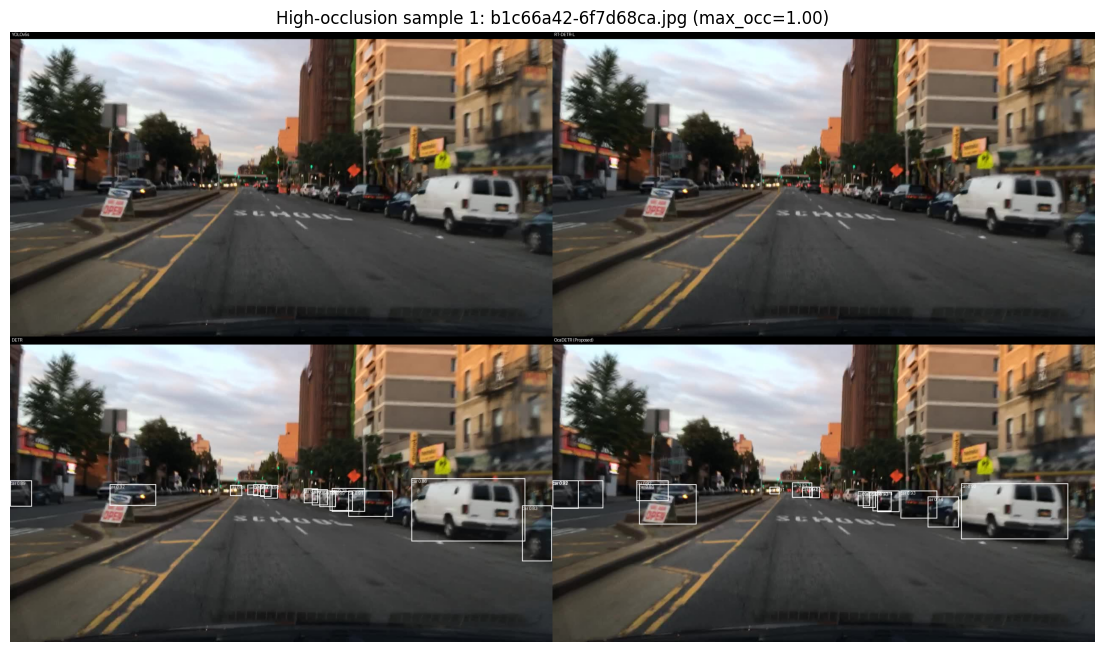

Saved: /kaggle/working/report_figs/qual_compare_01.png


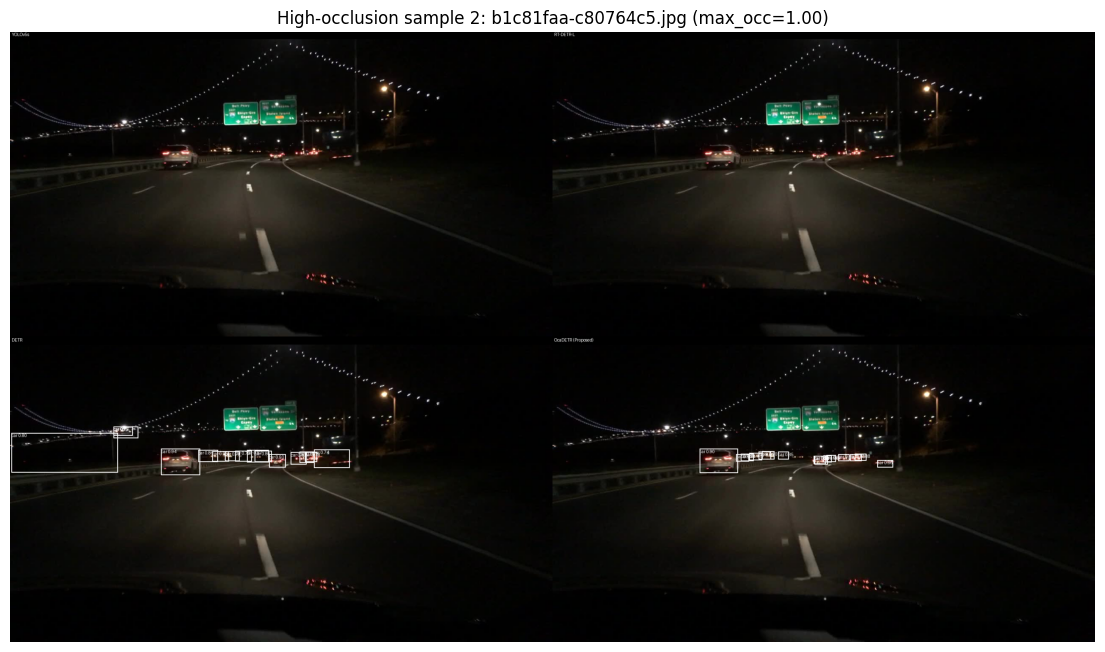

Saved: /kaggle/working/report_figs/qual_compare_02.png


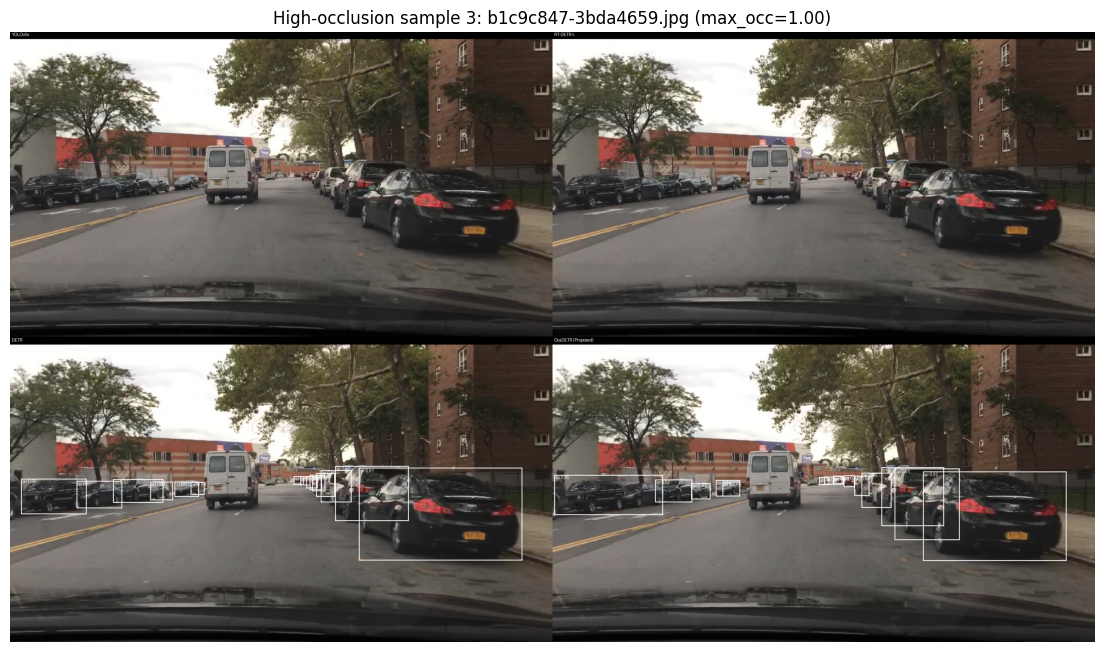

Saved: /kaggle/working/report_figs/qual_compare_03.png


In [11]:
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List, Dict
import random
import torch
from PIL import Image, ImageDraw, ImageFont

# -----------------------------
# Robust weight picker (works even if Ultralytics created *_2 folders or 'train' folders)
# -----------------------------
def _latest_dir_with_weights(detect_root: Path, prefixes: List[str]) -> Optional[Path]:
    if not detect_root.exists():
        return None
    cand = []
    for p in detect_root.iterdir():
        if not p.is_dir():
            continue
        if any(p.name.startswith(pref) for pref in prefixes):
            wdir = p / "weights"
            if (wdir / "best.pt").exists() or (wdir / "last.pt").exists():
                cand.append(p)
    if not cand:
        return None
    cand.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return cand[0]

def pick_weights(project_root: Path, run_name: str) -> Optional[Path]:
    detect_root = project_root / "detect"
    run_dir = _latest_dir_with_weights(detect_root, prefixes=[run_name])
    # fallback: common Ultralytics default names
    if run_dir is None:
        run_dir = _latest_dir_with_weights(detect_root, prefixes=["train", "exp", "val"])
    if run_dir is None:
        return None
    best = run_dir / "weights" / "best.pt"
    last = run_dir / "weights" / "last.pt"
    if best.exists():
        return best
    if last.exists():
        return last
    return None

# -----------------------------
# Select high-occlusion samples
# -----------------------------
OCC_THR = 0.6
NUM_SAMPLES = 3
SCORE_THR = 0.30
TOPK = 15

coco_val_dict = load_json(bdd_coco_val)

# contiguous label -> name for DETR/OcaDETR (matches our training setup)
cats_sorted = sorted(coco_val_dict["categories"], key=lambda x: int(x["id"]))
id2label_local = {i: c["name"] for i, c in enumerate(cats_sorted)}

# image_id -> max occlusion_ratio
max_occ = {}
for a in coco_val_dict["annotations"]:
    occ = float(a.get("occlusion_ratio", 0.0))
    if occ >= OCC_THR:
        img_id = int(a["image_id"])
        max_occ[img_id] = max(max_occ.get(img_id, 0.0), occ)

if max_occ:
    chosen_ids = [k for k, _ in sorted(max_occ.items(), key=lambda kv: kv[1], reverse=True)[:NUM_SAMPLES]]
else:
    chosen_ids = [im["id"] for im in random.sample(coco_val_dict["images"], k=min(NUM_SAMPLES, len(coco_val_dict["images"])))]
    print(f"⚠️ No high-occlusion annotations found (occ_ratio>={OCC_THR:.2f}). Showing random samples instead.")

id_to_img = {int(im["id"]): im for im in coco_val_dict["images"]}

# -----------------------------
# Load models
# -----------------------------
yolo_model_vis = None
rtdetr_model_vis = None
detr_model_vis = None
detr_proc_vis = None
ocadetr_model_vis = None

# YOLOv5s
try:
    from ultralytics import YOLO
    w = pick_weights(WORK / "runs", "yolov5s_bdd")
    if w is None:
        raise FileNotFoundError("YOLO weights not found under WORK/runs/detect/. Run Cell 6 (training) first.")
    yolo_model_vis = YOLO(str(w))
    # model.names can be dict or list
    yolo_names = yolo_model_vis.names
except Exception as e:
    print("⚠️ YOLOv5s not available:", e)
    yolo_names = None

# RT-DETR
try:
    from ultralytics import YOLO
    w = pick_weights(WORK / "runs", "rtdetr_l_bdd")
    if w is None:
        raise FileNotFoundError("RT-DETR weights not found under WORK/runs/detect/. Run Cell 6 (training) first.")
    rtdetr_model_vis = YOLO(str(w))
    rtdetr_names = rtdetr_model_vis.names
except Exception as e:
    print("⚠️ RT-DETR not available:", e)
    rtdetr_names = None

# DETR
try:
    from transformers import DetrForObjectDetection, DetrImageProcessor
    detr_dir = WORK / "checkpoints/detr"
    detr_model_vis = DetrForObjectDetection.from_pretrained(str(detr_dir)).to(DEVICE)
    detr_proc_vis  = DetrImageProcessor.from_pretrained(str(detr_dir))
except Exception as e:
    print("⚠️ DETR not available:", e)

# OcaDETR
try:
    from transformers import DetrForObjectDetection, DetrImageProcessor
    ckpt = torch.load(WORK / "checkpoints/ocadetr.pt", map_location=DEVICE)
    base2 = DetrForObjectDetection.from_pretrained(
        "facebook/detr-resnet-50",
        num_labels=ckpt["num_labels"],
        ignore_mismatched_sizes=True
    ).to(DEVICE)
    ocadetr_model_vis = OcaDETR(base2, lambda_occ=LAMBDA_OCC).to(DEVICE)
    ocadetr_model_vis.load_state_dict(ckpt["state_dict"], strict=False)
    if detr_proc_vis is None:
        detr_proc_vis = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
except Exception as e:
    print("⚠️ OcaDETR not available:", e)

# -----------------------------
# Prediction helpers (per image)
# -----------------------------
def _names_lookup(names_obj, cls_id: int) -> str:
    if names_obj is None:
        return str(cls_id)
    if isinstance(names_obj, dict):
        return str(names_obj.get(cls_id, cls_id))
    # list/tuple
    if 0 <= cls_id < len(names_obj):
        return str(names_obj[cls_id])
    return str(cls_id)

def _yolo_preds_one(model, names_obj, img_path: Path, score_thr: float) -> List[Dict]:
    if model is None:
        return []
    r = model.predict(source=str(img_path), conf=score_thr, device=0 if DEVICE == "cuda" else "cpu", verbose=False)[0]
    preds = []
    if r.boxes is None:
        return preds
    for b in r.boxes:
        score = float(b.conf[0].cpu().item())
        cls   = int(b.cls[0].cpu().item())
        x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
        name = _names_lookup(names_obj, cls)
        preds.append({"box": [x1, y1, x2, y2], "score": score, "label": name})
    preds.sort(key=lambda d: d["score"], reverse=True)
    return preds[:TOPK]

def _detr_preds_one(model, processor, img: Image.Image, im_w: int, im_h: int, score_thr: float) -> List[Dict]:
    if model is None or processor is None:
        return []
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    target_sizes = torch.tensor([[im_h, im_w]], device=DEVICE)
    res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=score_thr)[0]
    preds = []
    for score, label, box in zip(res["scores"], res["labels"], res["boxes"]):
        x1, y1, x2, y2 = box.tolist()
        lab = int(label.item())
        name = id2label_local.get(lab, str(lab))
        preds.append({"box": [x1, y1, x2, y2], "score": float(score.item()), "label": name})
    preds.sort(key=lambda d: d["score"], reverse=True)
    return preds[:TOPK]

def _ocadetr_preds_one(model, processor, img: Image.Image, im_w: int, im_h: int, score_thr: float) -> List[Dict]:
    if model is None or processor is None:
        return []
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        g = torch.sigmoid(model.oam(inputs["pixel_values"]))
        x = inputs["pixel_values"] * (0.5 + g)
        outputs = model.detr(pixel_values=x)
    target_sizes = torch.tensor([[im_h, im_w]], device=DEVICE)
    res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=score_thr)[0]
    preds = []
    for score, label, box in zip(res["scores"], res["labels"], res["boxes"]):
        x1, y1, x2, y2 = box.tolist()
        lab = int(label.item())
        name = id2label_local.get(lab, str(lab))
        preds.append({"box": [x1, y1, x2, y2], "score": float(score.item()), "label": name})
    preds.sort(key=lambda d: d["score"], reverse=True)
    return preds[:TOPK]

# -----------------------------
# Drawing helpers
# -----------------------------
def annotate(img: Image.Image, preds: List[Dict], header: str) -> Image.Image:
    im = img.copy()
    draw = ImageDraw.Draw(im)
    font = ImageFont.load_default()

    draw.rectangle([0, 0, im.size[0], 18], fill=(0, 0, 0))
    draw.text((4, 2), header, font=font, fill=(255, 255, 255))

    for p in preds:
        x1, y1, x2, y2 = p["box"]
        draw.rectangle([x1, y1, x2, y2], outline=(255, 255, 255), width=2)
        txt = f"{p['label']} {p['score']:.2f}"
        tx, ty = max(0, x1), max(18, y1)
        draw.text((tx, ty), txt, font=font, fill=(255, 255, 255))
    return im

def make_collage(tl: Image.Image, tr: Image.Image, bl: Image.Image, br: Image.Image) -> Image.Image:
    w, h = tl.size
    canvas = Image.new("RGB", (2 * w, 2 * h))
    canvas.paste(tl, (0, 0))
    canvas.paste(tr, (w, 0))
    canvas.paste(bl, (0, h))
    canvas.paste(br, (w, h))
    return canvas

# -----------------------------
# Run and save
# -----------------------------
out_dir = WORK / "report_figs"
out_dir.mkdir(parents=True, exist_ok=True)

for idx, img_id in enumerate(chosen_ids, start=1):
    im_meta = id_to_img[int(img_id)]
    img_path = resolve_from_roots(im_meta["file_name"], VAL_ROOTS)
    if not img_path:
        print("Skipping (missing):", im_meta["file_name"])
        continue

    img = Image.open(img_path).convert("RGB")
    im_w, im_h = img.size

    y_pred = _yolo_preds_one(yolo_model_vis, yolo_names, img_path, SCORE_THR)
    r_pred = _yolo_preds_one(rtdetr_model_vis, rtdetr_names, img_path, SCORE_THR)
    d_pred = _detr_preds_one(detr_model_vis, detr_proc_vis, img, im_w, im_h, SCORE_THR)
    o_pred = _ocadetr_preds_one(ocadetr_model_vis, detr_proc_vis, img, im_w, im_h, SCORE_THR)

    tl = annotate(img, y_pred, "YOLOv5s")
    tr = annotate(img, r_pred, "RT-DETR-L")
    bl = annotate(img, d_pred, "DETR")
    br = annotate(img, o_pred, "OcaDETR (Proposed)")

    collage = make_collage(tl, tr, bl, br)

    out_png = out_dir / f"qual_compare_{idx:02d}.png"
    collage.save(out_png)

    plt.figure(figsize=(14, 10))
    plt.imshow(collage)
    plt.axis("off")
    plt.title(f"High-occlusion sample {idx}: {im_meta['file_name']} (max_occ={max_occ.get(int(img_id), 0.0):.2f})")
    plt.show()

    print("Saved:", out_png)


XAI sample: b1c66a42-6f7d68ca.jpg size: (1280, 720)
DETR top detection -> query=76, class=2, prob=0.916


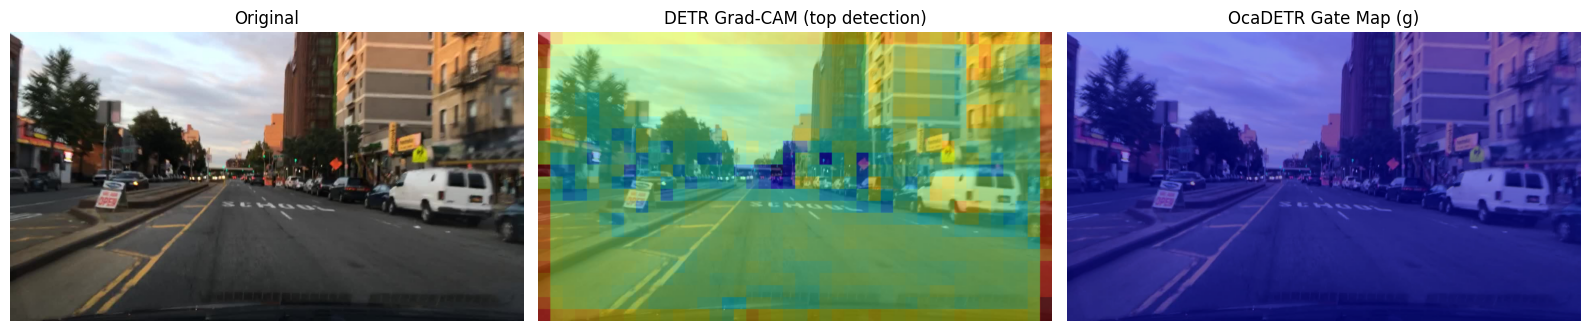

Saved:
 - /kaggle/working/report_figs/xai_detr_gradcam.png
 - /kaggle/working/report_figs/xai_ocadetr_gate.png
 - /kaggle/working/report_figs/xai_compare_detr_vs_ocadetr.png


In [12]:
# -----------------------------
# 11) Explainable AI (XAI): DETR Grad-CAM vs OcaDETR Gate Map
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image

from captum.attr import LayerGradCam, LayerAttribution


# ---- Helpers: robust model availability ----
def _ensure_detr_loaded():
    """Ensure detr_model_vis + detr_proc_vis exist (load from checkpoints if needed)."""
    global detr_model_vis, detr_proc_vis
    if "detr_model_vis" in globals() and detr_model_vis is not None and "detr_proc_vis" in globals() and detr_proc_vis is not None:
        return

    from transformers import DetrForObjectDetection, DetrImageProcessor
    detr_dir = WORK / "checkpoints/detr"
    detr_model_vis = DetrForObjectDetection.from_pretrained(str(detr_dir)).to(DEVICE)
    detr_proc_vis  = DetrImageProcessor.from_pretrained(str(detr_dir))


def _ensure_ocadetr_loaded():
    """Ensure ocadetr_model_vis exists (load from checkpoint if needed)."""
    global ocadetr_model_vis, detr_proc_vis
    if "ocadetr_model_vis" in globals() and ocadetr_model_vis is not None:
        return

    from transformers import DetrForObjectDetection, DetrImageProcessor
    ckpt = torch.load(WORK / "checkpoints/ocadetr.pt", map_location=DEVICE)
    base2 = DetrForObjectDetection.from_pretrained(
        "facebook/detr-resnet-50",
        num_labels=ckpt["num_labels"],
        ignore_mismatched_sizes=True
    ).to(DEVICE)

    ocadetr_model_vis = OcaDETR(base2, lambda_occ=LAMBDA_OCC).to(DEVICE)
    ocadetr_model_vis.load_state_dict(ckpt["state_dict"], strict=False)

    if "detr_proc_vis" not in globals() or detr_proc_vis is None:
        detr_proc_vis = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


def _overlay_heatmap_on_image(img_pil: Image.Image, heat: np.ndarray, alpha: float = 0.45):
    """
    heat: 2D array in [0..1] same size as image (H,W)
    returns overlay image (numpy RGB uint8)
    """
    heat = np.clip(heat, 0.0, 1.0)
    img = np.array(img_pil).astype(np.float32) / 255.0
    cmap = plt.get_cmap("jet")
    hm = cmap(heat)[:, :, :3]  # RGB
    out = (1 - alpha) * img + alpha * hm
    out = (np.clip(out, 0.0, 1.0) * 255).astype(np.uint8)
    return out


# ---- Choose a sample image (use high-occlusion chosen_ids if available) ----
coco_val_dict = load_json(bdd_coco_val)
id_to_img = {int(im["id"]): im for im in coco_val_dict["images"]}

# Prefer the same chosen_ids from Cell 10 if present, else pick a random val image
if "chosen_ids" in globals() and len(chosen_ids) > 0:
    sample_img_id = int(chosen_ids[0])
else:
    sample_img_id = int(coco_val_dict["images"][0]["id"])

im_meta = id_to_img[sample_img_id]
img_path = resolve_from_roots(im_meta["file_name"], VAL_ROOTS)
assert img_path is not None, f"Image not found: {im_meta['file_name']}"

img = Image.open(img_path).convert("RGB")
W, H = img.size
print("XAI sample:", im_meta["file_name"], "size:", (W, H))


# ---- Load models ----
_ensure_detr_loaded()
_ensure_ocadetr_loaded()

detr_model_vis.eval()
ocadetr_model_vis.eval()


# -----------------------------
# A) DETR Grad-CAM (for the top predicted detection)
# -----------------------------
# 1) Run DETR once to pick the top detection (query + class)
inputs = detr_proc_vis(images=img, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    out = detr_model_vis(**inputs)  # out.logits: [1, num_queries, num_classes+1]

logits = out.logits[0]  # [Q, C+1]
probs = logits.softmax(-1)[:, :-1]  # drop "no-object"
best_score = float(probs.max().item())
best_q, best_c = np.unravel_index(int(probs.argmax().item()), probs.shape)
print(f"DETR top detection -> query={best_q}, class={best_c}, prob={best_score:.3f}")

# 2) Build a wrapper that returns ONLY that scalar probability (needed by Captum)
class DetrScoreWrapper(nn.Module):
    def __init__(self, detr_model):
        super().__init__()
        self.m = detr_model

    def forward(self, pixel_values, pixel_mask, q_idx: int, c_idx: int):
        out = self.m(pixel_values=pixel_values, pixel_mask=pixel_mask)
        probs = out.logits.softmax(-1)[:, :, :-1]  # [B,Q,C]
        # return [B] tensor
        return probs[:, q_idx, c_idx]

wrapper = DetrScoreWrapper(detr_model_vis).to(DEVICE).eval()

# 3) Pick the target layer (ResNet layer4 is usually best for Grad-CAM)
# NOTE: This is the common HF DETR backbone path.
target_layer = detr_model_vis.model.backbone.conv_encoder.model.layer4[-1]

# 4) Compute Grad-CAM
lgc = LayerGradCam(wrapper, target_layer)
attr = lgc.attribute(
    inputs=inputs["pixel_values"],
    additional_forward_args=(inputs["pixel_mask"], int(best_q), int(best_c))
)  # shape ~ [1, 1, h, w]

# Upsample to input tensor size (processor padded size), then crop to image size
attr_up = LayerAttribution.interpolate(attr, inputs["pixel_values"].shape[-2:])  # [1,1,Hp,Wp]
heat = attr_up[0, 0].detach().cpu().numpy()
heat = heat - heat.min()
heat = heat / (heat.max() + 1e-6)

# Convert to original image size: processor keeps original size in img, so just resize heat to (H,W)
heat_img = Image.fromarray((heat * 255).astype(np.uint8)).resize((W, H), resample=Image.BILINEAR)
heat_np = np.array(heat_img).astype(np.float32) / 255.0

detr_gradcam_overlay = _overlay_heatmap_on_image(img, heat_np, alpha=0.45)


# -----------------------------
# B) OcaDETR Gate Map (g) overlay (your proposed XAI signal)
# -----------------------------
with torch.no_grad():
    # OcaDETR expects the same pixel_values; gate map g is at padded resolution
    pv = inputs["pixel_values"]
    g = torch.sigmoid(ocadetr_model_vis.oam(pv))  # [1,1,Hp,Wp]
    g_np = g[0, 0].detach().cpu().numpy()
    g_np = (g_np - g_np.min()) / (g_np.max() + 1e-6)

g_img = Image.fromarray((g_np * 255).astype(np.uint8)).resize((W, H), resample=Image.BILINEAR)
g_np_resized = np.array(g_img).astype(np.float32) / 255.0

ocadetr_gate_overlay = _overlay_heatmap_on_image(img, g_np_resized, alpha=0.45)


# -----------------------------
# C) Save + show
# -----------------------------
out_dir = WORK / "report_figs"
out_dir.mkdir(parents=True, exist_ok=True)

detr_out = out_dir / "xai_detr_gradcam.png"
oca_out  = out_dir / "xai_ocadetr_gate.png"
combo_out = out_dir / "xai_compare_detr_vs_ocadetr.png"

Image.fromarray(detr_gradcam_overlay).save(detr_out)
Image.fromarray(ocadetr_gate_overlay).save(oca_out)

# Side-by-side figure
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(detr_gradcam_overlay)
plt.axis("off")
plt.title("DETR Grad-CAM (top detection)")

plt.subplot(1, 3, 3)
plt.imshow(ocadetr_gate_overlay)
plt.axis("off")
plt.title("OcaDETR Gate Map (g)")

plt.tight_layout()
plt.savefig(combo_out, dpi=200)
plt.show()

print("Saved:")
print(" -", detr_out)
print(" -", oca_out)
print(" -", combo_out)


Sensitivity sample: b1c66a42-6f7d68ca.jpg size: (1280, 720)
DETR target:   q=76, c=2, base_score=0.9156
OcaDETR target: q=25, c=2, base_score=0.9361


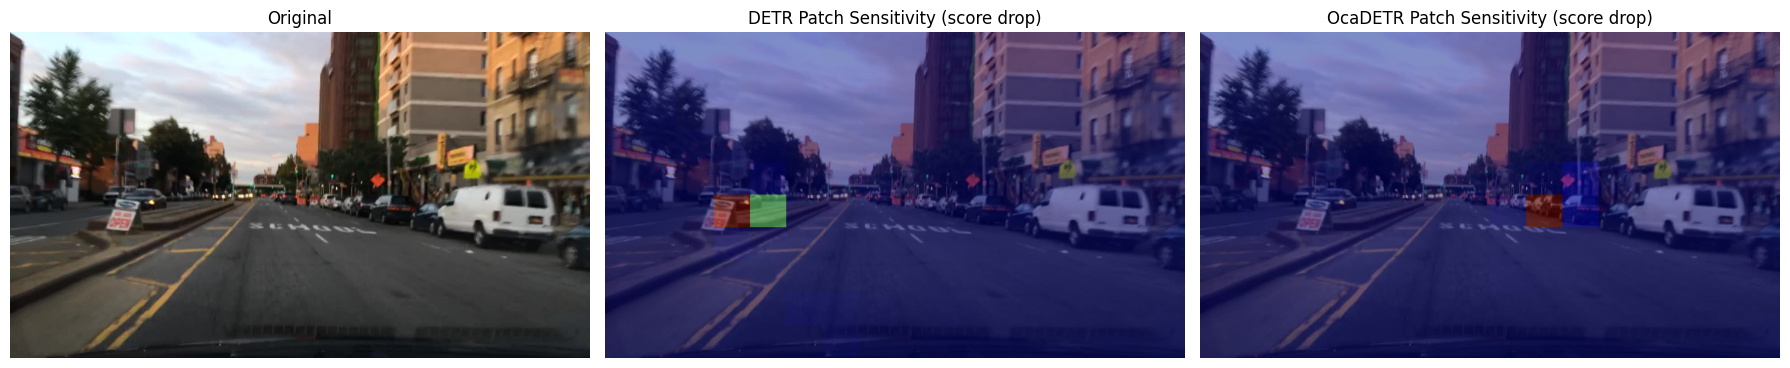

Saved: /kaggle/working/report_figs/xai_patch_sensitivity_detr_vs_ocadetr.png
Tip: In report, explain 'red zones cause biggest confidence drop when occluded'.


In [13]:
# -----------------------------
# 12) Patch-Occlusion Sensitivity Test (DETR vs OcaDETR)
# -----------------------------
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# ---- Config ----
GRID_H = 10          # number of rows
GRID_W = 16          # number of cols
FILL_MODE = "gray"   # "black" or "gray"
SCORE_THR = 0.0      # keep 0.0 for sensitivity (we want raw score movement)
USE_SAME_IMAGE_AS_XAI = True  # uses sample_img_id from prior XAI cell if available

out_dir = WORK / "report_figs"
out_dir.mkdir(parents=True, exist_ok=True)

# ---- Pick image (use the same one as XAI if possible) ----
coco_val_dict = load_json(bdd_coco_val)
id_to_img = {int(im["id"]): im for im in coco_val_dict["images"]}

if USE_SAME_IMAGE_AS_XAI and "sample_img_id" in globals():
    img_id = int(sample_img_id)
else:
    # fallback: use first chosen high-occ image if present
    if "chosen_ids" in globals() and len(chosen_ids) > 0:
        img_id = int(chosen_ids[0])
    else:
        img_id = int(coco_val_dict["images"][0]["id"])

im_meta = id_to_img[img_id]
img_path = resolve_from_roots(im_meta["file_name"], VAL_ROOTS)
assert img_path is not None, f"Image not found: {im_meta['file_name']}"

img = Image.open(img_path).convert("RGB")
W, H = img.size
print("Sensitivity sample:", im_meta["file_name"], "size:", (W, H))

# ---- Ensure models exist (from previous XAI cell) ----
# Expected globals: detr_model_vis, detr_proc_vis, ocadetr_model_vis
assert detr_model_vis is not None and detr_proc_vis is not None, "DETR not loaded. Run Cell 11 first."
assert ocadetr_model_vis is not None and detr_proc_vis is not None, "OcaDETR not loaded. Run Cell 11 first."

detr_model_vis.eval()
ocadetr_model_vis.eval()

# ---- Utility: get "top detection" target (query, class) for DETR-style outputs ----
def get_top_target_detr(model, processor, image_pil: Image.Image, use_ocadetr_gate: bool = False):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        if not use_ocadetr_gate:
            out = model(**inputs)  # DETR normal
        else:
            # OcaDETR inference: gate + DAF, then DETR head
            g = torch.sigmoid(ocadetr_model_vis.oam(inputs["pixel_values"]))
            x = inputs["pixel_values"] * (0.5 + g)
            out = ocadetr_model_vis.detr(pixel_values=x)

    logits = out.logits[0]  # [Q, C+1]
    probs = logits.softmax(-1)[:, :-1]  # drop no-object
    best_score = float(probs.max().item())
    best_q, best_c = np.unravel_index(int(probs.argmax().item()), probs.shape)
    return int(best_q), int(best_c), best_score

# ---- Utility: score for a fixed target (query, class) ----
def target_score_detr(model, processor, image_pil: Image.Image, q_idx: int, c_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs)
        probs = out.logits.softmax(-1)[0, :, :-1]  # [Q,C]
        return float(probs[q_idx, c_idx].item())

def target_score_ocadetr(model, processor, image_pil: Image.Image, q_idx: int, c_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        g = torch.sigmoid(model.oam(inputs["pixel_values"]))
        x = inputs["pixel_values"] * (0.5 + g)
        out = model.detr(pixel_values=x)
        probs = out.logits.softmax(-1)[0, :, :-1]  # [Q,C]
        return float(probs[q_idx, c_idx].item())

# ---- Baseline targets (each model uses its OWN top detection) ----
d_q, d_c, d_base = get_top_target_detr(detr_model_vis, detr_proc_vis, img, use_ocadetr_gate=False)
o_q, o_c, o_base = get_top_target_detr(detr_model_vis, detr_proc_vis, img, use_ocadetr_gate=True)

print(f"DETR target:   q={d_q}, c={d_c}, base_score={d_base:.4f}")
print(f"OcaDETR target: q={o_q}, c={o_c}, base_score={o_base:.4f}")

# ---- Create grid patches ----
patch_w = W // GRID_W
patch_h = H // GRID_H

def mask_patch(image_pil: Image.Image, r: int, c: int):
    im = image_pil.copy()
    draw = ImageDraw.Draw(im)
    x1 = c * patch_w
    y1 = r * patch_h
    x2 = (c + 1) * patch_w if c < GRID_W - 1 else W
    y2 = (r + 1) * patch_h if r < GRID_H - 1 else H

    if FILL_MODE == "black":
        fill = (0, 0, 0)
    else:
        # gray = mean-ish occlusion
        fill = (127, 127, 127)

    draw.rectangle([x1, y1, x2, y2], fill=fill)
    return im, (x1, y1, x2, y2)

# ---- Run sensitivity scan ----
d_drop = np.zeros((GRID_H, GRID_W), dtype=np.float32)
o_drop = np.zeros((GRID_H, GRID_W), dtype=np.float32)

for r in range(GRID_H):
    for c in range(GRID_W):
        im_occ, _ = mask_patch(img, r, c)

        d_s = target_score_detr(detr_model_vis, detr_proc_vis, im_occ, d_q, d_c)
        o_s = target_score_ocadetr(ocadetr_model_vis, detr_proc_vis, im_occ, o_q, o_c)

        # normalized drop (0..1-ish)
        d_drop[r, c] = max(0.0, (d_base - d_s) / (d_base + 1e-8))
        o_drop[r, c] = max(0.0, (o_base - o_s) / (o_base + 1e-8))

# ---- Upsample grid to image size (nearest) for overlay ----
def upsample_grid_to_image(grid: np.ndarray, W: int, H: int):
    g = np.kron(grid, np.ones((patch_h, patch_w), dtype=np.float32))
    # fix last row/col sizes
    g = g[:H, :W]
    if g.shape[0] < H or g.shape[1] < W:
        out = np.zeros((H, W), dtype=np.float32)
        out[:g.shape[0], :g.shape[1]] = g
        g = out
    return g

d_map = upsample_grid_to_image(d_drop, W, H)
o_map = upsample_grid_to_image(o_drop, W, H)

# normalize for nicer plots
d_map_n = (d_map - d_map.min()) / (d_map.max() - d_map.min() + 1e-6)
o_map_n = (o_map - o_map.min()) / (o_map.max() - o_map.min() + 1e-6)

# ---- Plot + save ----
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(img)
ax1.axis("off")
ax1.set_title("Original")

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(img)
ax2.imshow(d_map_n, alpha=0.45, cmap="jet")
ax2.axis("off")
ax2.set_title("DETR Patch Sensitivity (score drop)")

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(img)
ax3.imshow(o_map_n, alpha=0.45, cmap="jet")
ax3.axis("off")
ax3.set_title("OcaDETR Patch Sensitivity (score drop)")

plt.tight_layout()

out_png = out_dir / "xai_patch_sensitivity_detr_vs_ocadetr.png"
plt.savefig(out_png, dpi=200)
plt.show()

print("Saved:", out_png)
print("Tip: In report, explain 'red zones cause biggest confidence drop when occluded'.")


Per-class sensitivity image: b1ca2e5d-84cf9134.jpg size: (1280, 720) class: person
DETR  class='person' q=80 base=0.1961
OcaDETR class='person' q=12 base=0.6971

Top sensitive patches (DETR):
  patch(r=7,c=11) drop=0.798
  patch(r=7,c=8) drop=0.471
  patch(r=3,c=12) drop=0.264
  patch(r=6,c=14) drop=0.224
  patch(r=3,c=0) drop=0.185


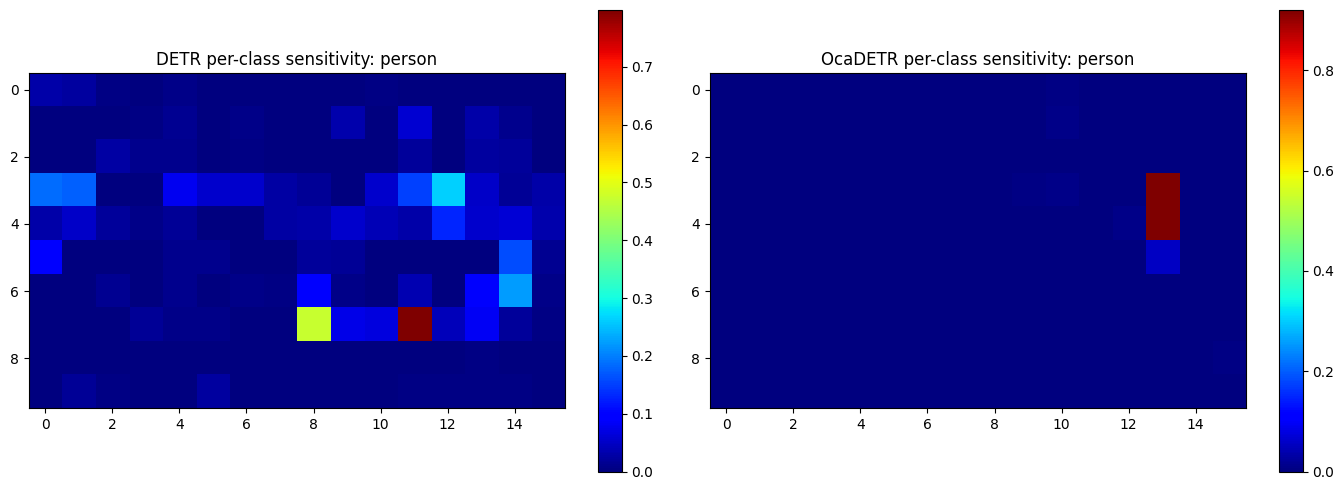

In [14]:
# -----------------------------
# 13) Per-class Patch Sensitivity (single image)
# -----------------------------
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# ---- Config ----
TARGET_CLASS_NAME = "person"  # change to: car, bus, truck, rider, bicycle, motorcycle, traffic light, traffic sign, train
GRID_H = 10
GRID_W = 16
FILL_MODE = "gray"  # "black" or "gray"
NUM_PATCHES_TO_PRINT = 5

# ---- Load val + mappings ----
coco_val_dict = load_json(bdd_coco_val)
id_to_img = {int(im["id"]): im for im in coco_val_dict["images"]}
cats_sorted = sorted(coco_val_dict["categories"], key=lambda x: int(x["id"]))
id2label_local = {i: c["name"] for i, c in enumerate(cats_sorted)}
label2id_local = {v: k for k, v in id2label_local.items()}

assert TARGET_CLASS_NAME in label2id_local, f"Class '{TARGET_CLASS_NAME}' not in dataset classes: {list(label2id_local.keys())}"
target_c_idx = int(label2id_local[TARGET_CLASS_NAME])

# ---- Pick an image that contains this class (prefer high-occlusion if available) ----
anns_by_img = {}
for a in coco_val_dict["annotations"]:
    anns_by_img.setdefault(int(a["image_id"]), []).append(a)

def pick_image_with_class(target_name: str, occ_thr: float = 0.6):
    # Prefer images where this class has occlusion_ratio >= occ_thr
    target_catid = None
    for c in coco_val_dict["categories"]:
        if c["name"] == target_name:
            target_catid = int(c["id"])
            break
    if target_catid is None:
        return int(coco_val_dict["images"][0]["id"])

    hi = []
    lo = []
    for im in coco_val_dict["images"]:
        img_id = int(im["id"])
        anns = anns_by_img.get(img_id, [])
        hit_hi = any(int(a["category_id"]) == target_catid and float(a.get("occlusion_ratio", 0.0)) >= occ_thr for a in anns)
        hit_lo = any(int(a["category_id"]) == target_catid for a in anns)
        if hit_hi:
            hi.append(img_id)
        elif hit_lo:
            lo.append(img_id)

    if hi:
        return hi[0]
    if lo:
        return lo[0]
    return int(coco_val_dict["images"][0]["id"])

img_id = pick_image_with_class(TARGET_CLASS_NAME, occ_thr=0.6)
im_meta = id_to_img[img_id]
img_path = resolve_from_roots(im_meta["file_name"], VAL_ROOTS)
assert img_path is not None, f"Image not found: {im_meta['file_name']}"

img = Image.open(img_path).convert("RGB")
W, H = img.size
print("Per-class sensitivity image:", im_meta["file_name"], "size:", (W, H), "class:", TARGET_CLASS_NAME)

# ---- Ensure models exist ----
assert detr_model_vis is not None and detr_proc_vis is not None, "DETR not loaded. Run Cell 11 first."
assert ocadetr_model_vis is not None and detr_proc_vis is not None, "OcaDETR not loaded. Run Cell 11 first."

detr_model_vis.eval()
ocadetr_model_vis.eval()

# ---- Helpers: choose best query for a specific class ----
def best_query_for_class_detr(model, processor, image_pil: Image.Image, class_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs)
    probs = out.logits.softmax(-1)[0, :, :-1]  # [Q,C]
    scores = probs[:, class_idx]
    q = int(scores.argmax().item())
    s = float(scores[q].item())
    return q, class_idx, s

def best_query_for_class_ocadetr(model, processor, image_pil: Image.Image, class_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        g = torch.sigmoid(model.oam(inputs["pixel_values"]))
        x = inputs["pixel_values"] * (0.5 + g)
        out = model.detr(pixel_values=x)
    probs = out.logits.softmax(-1)[0, :, :-1]  # [Q,C]
    scores = probs[:, class_idx]
    q = int(scores.argmax().item())
    s = float(scores[q].item())
    return q, class_idx, s

def target_score_detr(model, processor, image_pil: Image.Image, q_idx: int, c_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs)
        probs = out.logits.softmax(-1)[0, :, :-1]
    return float(probs[q_idx, c_idx].item())

def target_score_ocadetr(model, processor, image_pil: Image.Image, q_idx: int, c_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        g = torch.sigmoid(model.oam(inputs["pixel_values"]))
        x = inputs["pixel_values"] * (0.5 + g)
        out = model.detr(pixel_values=x)
        probs = out.logits.softmax(-1)[0, :, :-1]
    return float(probs[q_idx, c_idx].item())

# ---- Baseline per-class target ----
d_q, d_c, d_base = best_query_for_class_detr(detr_model_vis, detr_proc_vis, img, target_c_idx)
o_q, o_c, o_base = best_query_for_class_ocadetr(ocadetr_model_vis, detr_proc_vis, img, target_c_idx)

print(f"DETR  class='{TARGET_CLASS_NAME}' q={d_q} base={d_base:.4f}")
print(f"OcaDETR class='{TARGET_CLASS_NAME}' q={o_q} base={o_base:.4f}")

# ---- Patch mask ----
patch_w = W // GRID_W
patch_h = H // GRID_H

def mask_patch(image_pil: Image.Image, r: int, c: int):
    im = image_pil.copy()
    draw = ImageDraw.Draw(im)
    x1 = c * patch_w
    y1 = r * patch_h
    x2 = (c + 1) * patch_w if c < GRID_W - 1 else W
    y2 = (r + 1) * patch_h if r < GRID_H - 1 else H
    fill = (0, 0, 0) if FILL_MODE == "black" else (127, 127, 127)
    draw.rectangle([x1, y1, x2, y2], fill=fill)
    return im

d_drop = np.zeros((GRID_H, GRID_W), dtype=np.float32)
o_drop = np.zeros((GRID_H, GRID_W), dtype=np.float32)

for r in range(GRID_H):
    for c in range(GRID_W):
        im_occ = mask_patch(img, r, c)
        d_s = target_score_detr(detr_model_vis, detr_proc_vis, im_occ, d_q, d_c)
        o_s = target_score_ocadetr(ocadetr_model_vis, detr_proc_vis, im_occ, o_q, o_c)
        d_drop[r, c] = max(0.0, (d_base - d_s) / (d_base + 1e-8))
        o_drop[r, c] = max(0.0, (o_base - o_s) / (o_base + 1e-8))

# Print most sensitive patches
flat = [(d_drop[r,c], r, c) for r in range(GRID_H) for c in range(GRID_W)]
flat.sort(reverse=True)
print("\nTop sensitive patches (DETR):")
for k in range(min(NUM_PATCHES_TO_PRINT, len(flat))):
    v,r,c = flat[k]
    print(f"  patch(r={r},c={c}) drop={v:.3f}")

# Plot heatmaps
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(d_drop, cmap="jet")
plt.colorbar()
plt.title(f"DETR per-class sensitivity: {TARGET_CLASS_NAME}")
plt.subplot(1,2,2)
plt.imshow(o_drop, cmap="jet")
plt.colorbar()
plt.title(f"OcaDETR per-class sensitivity: {TARGET_CLASS_NAME}")
plt.tight_layout()
plt.show()


Found 120 candidates for class='person' occ>=0.6.
Using N = 10


Avg sensitivity: 100%|██████████| 10/10 [03:28<00:00, 20.86s/it]


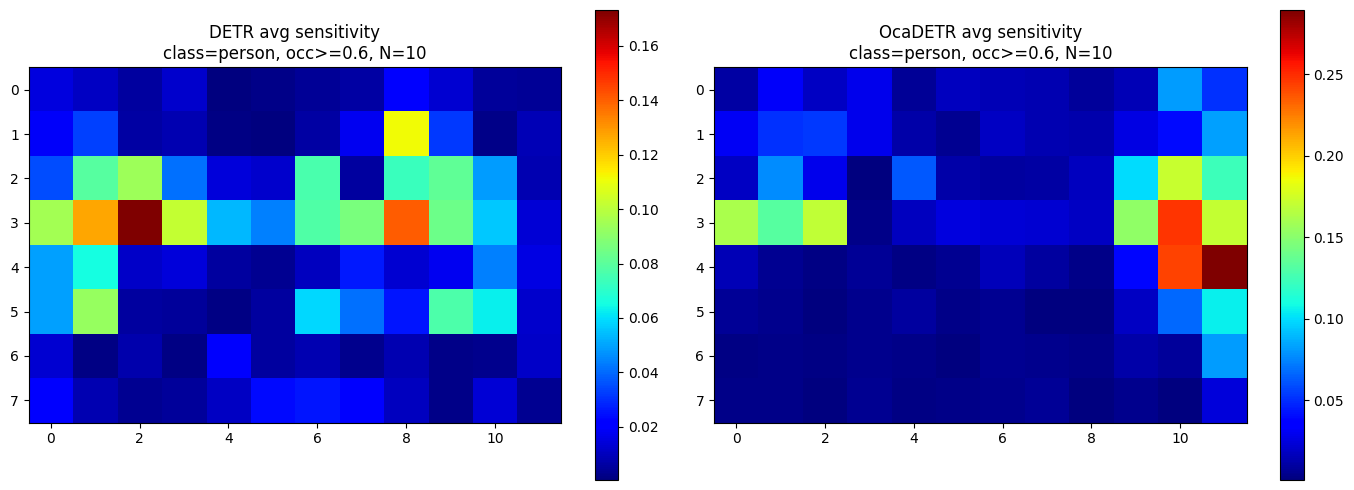

Saved: /kaggle/working/report_figs/xai_avg_patch_sensitivity_person_occ0.60_N10.png


file  DETR base score  OcaDETR base score  DETR mean drop  \
0  b1ca2e5d-84cf9134.jpg         0.196053            0.697062        0.043691   
1  b1ceb32e-3f481b43.jpg         0.058706            0.102230        0.025462   
2  b1ceb32e-51852abe.jpg         0.158626            0.106249        0.026157   
3  b1ceb32e-a106591d.jpg         0.059085            0.077883        0.047657   
4  b1d0a191-03dcecc2.jpg         0.240658            0.287004        0.031802   
5  b1d0a191-06deb55d.jpg         0.395299            0.454189        0.037497   
6  b1d0a191-28f0e779.jpg         0.054867            0.096168        0.021304   
7  b1d0a191-5490450b.jpg         0.062183            0.110523        0.012562   
8  b1d0a191-de8948f6.jpg         0.124642            0.107918        0.029006   
9  b1d10d08-da110fcb.jpg         0.194436            0.166499        0.028078   

   OcaDETR mean drop  
0           0.024750  
1           0.049687  
2           0.045675  
3           0.033102  
4           0.019484  
5           0.055195  
6           0.023534  
7           0.051434  
8           0.021385  
9           0.043838


Overall means:
DETR mean drop       0.030322
OcaDETR mean drop    0.036808
dtype: float64


In [15]:
# -----------------------------
# 14) Average Patch Sensitivity over N images (per-class + high-occlusion)
# -----------------------------
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm

# ---- Config ----
TARGET_CLASS_NAME = "person"   # choose class
OCC_THR = 0.6                  # only images where this class has occ >= thr
N_IMAGES = 10                  # increase to 25+ for stronger results (runtime increases)
GRID_H = 8                      # keep smaller for speed
GRID_W = 12
FILL_MODE = "gray"              # "black" or "gray"

# ---- Load val ----
coco_val_dict = load_json(bdd_coco_val)
id_to_img = {int(im["id"]): im for im in coco_val_dict["images"]}

# category_id lookup by name
name_to_catid = {c["name"]: int(c["id"]) for c in coco_val_dict["categories"]}
assert TARGET_CLASS_NAME in name_to_catid, f"Class '{TARGET_CLASS_NAME}' not present."
target_catid = name_to_catid[TARGET_CLASS_NAME]

# map COCO categories -> DETR contiguous class index (same ordering used in notebook)
cats_sorted = sorted(coco_val_dict["categories"], key=lambda x: int(x["id"]))
id2label_local = {i: c["name"] for i, c in enumerate(cats_sorted)}
label2id_local = {v: k for k, v in id2label_local.items()}
target_c_idx = int(label2id_local[TARGET_CLASS_NAME])

# group annotations
anns_by_img = {}
for a in coco_val_dict["annotations"]:
    anns_by_img.setdefault(int(a["image_id"]), []).append(a)

# choose candidate image_ids
candidates = []
for im in coco_val_dict["images"]:
    img_id = int(im["id"])
    anns = anns_by_img.get(img_id, [])
    hit = any(int(a["category_id"]) == target_catid and float(a.get("occlusion_ratio", 0.0)) >= OCC_THR for a in anns)
    if hit:
        candidates.append(img_id)

if not candidates:
    print(f"⚠️ No images found with class='{TARGET_CLASS_NAME}' and occlusion_ratio>={OCC_THR}.")
    print("   Try lowering OCC_THR (e.g., 0.3) OR use a different class.")
else:
    print(f"Found {len(candidates)} candidates for class='{TARGET_CLASS_NAME}' occ>={OCC_THR}.")

# sample N
candidates = candidates[:N_IMAGES]
print("Using N =", len(candidates))

# ---- Ensure models ----
assert detr_model_vis is not None and detr_proc_vis is not None, "DETR not loaded. Run Cell 11 first."
assert ocadetr_model_vis is not None and detr_proc_vis is not None, "OcaDETR not loaded. Run Cell 11 first."
detr_model_vis.eval()
ocadetr_model_vis.eval()

# ---- Helpers ----
def best_query_for_class_detr(model, processor, image_pil, class_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs)
    probs = out.logits.softmax(-1)[0, :, :-1]  # [Q,C]
    scores = probs[:, class_idx]
    q = int(scores.argmax().item())
    s = float(scores[q].item())
    return q, class_idx, s

def best_query_for_class_ocadetr(model, processor, image_pil, class_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        g = torch.sigmoid(model.oam(inputs["pixel_values"]))
        x = inputs["pixel_values"] * (0.5 + g)
        out = model.detr(pixel_values=x)
    probs = out.logits.softmax(-1)[0, :, :-1]
    scores = probs[:, class_idx]
    q = int(scores.argmax().item())
    s = float(scores[q].item())
    return q, class_idx, s

def target_score_detr(model, processor, image_pil, q_idx: int, c_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs)
        probs = out.logits.softmax(-1)[0, :, :-1]
    return float(probs[q_idx, c_idx].item())

def target_score_ocadetr(model, processor, image_pil, q_idx: int, c_idx: int):
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        g = torch.sigmoid(model.oam(inputs["pixel_values"]))
        x = inputs["pixel_values"] * (0.5 + g)
        out = model.detr(pixel_values=x)
        probs = out.logits.softmax(-1)[0, :, :-1]
    return float(probs[q_idx, c_idx].item())

# ---- Average sensitivity ----
d_sum = np.zeros((GRID_H, GRID_W), dtype=np.float32)
o_sum = np.zeros((GRID_H, GRID_W), dtype=np.float32)
rows = []

for img_id in tqdm(candidates, desc="Avg sensitivity"):
    im_meta = id_to_img[int(img_id)]
    img_path = resolve_from_roots(im_meta["file_name"], VAL_ROOTS)
    if not img_path:
        continue

    img = Image.open(img_path).convert("RGB")
    W, H = img.size
    patch_w = max(1, W // GRID_W)
    patch_h = max(1, H // GRID_H)

    # baseline targets for this class
    d_q, d_c, d_base = best_query_for_class_detr(detr_model_vis, detr_proc_vis, img, target_c_idx)
    o_q, o_c, o_base = best_query_for_class_ocadetr(ocadetr_model_vis, detr_proc_vis, img, target_c_idx)

    # skip if baseline is tiny (no real detection)
    if d_base < 1e-4 and o_base < 1e-4:
        continue

    d_drop = np.zeros((GRID_H, GRID_W), dtype=np.float32)
    o_drop = np.zeros((GRID_H, GRID_W), dtype=np.float32)

    def mask_patch(image_pil, r: int, c: int):
        im2 = image_pil.copy()
        draw = ImageDraw.Draw(im2)
        x1 = c * patch_w
        y1 = r * patch_h
        x2 = (c + 1) * patch_w if c < GRID_W - 1 else W
        y2 = (r + 1) * patch_h if r < GRID_H - 1 else H
        fill = (0, 0, 0) if FILL_MODE == "black" else (127, 127, 127)
        draw.rectangle([x1, y1, x2, y2], fill=fill)
        return im2

    for r in range(GRID_H):
        for c in range(GRID_W):
            im_occ = mask_patch(img, r, c)
            d_s = target_score_detr(detr_model_vis, detr_proc_vis, im_occ, d_q, d_c)
            o_s = target_score_ocadetr(ocadetr_model_vis, detr_proc_vis, im_occ, o_q, o_c)
            d_drop[r, c] = max(0.0, (d_base - d_s) / (d_base + 1e-8))
            o_drop[r, c] = max(0.0, (o_base - o_s) / (o_base + 1e-8))

    d_sum += d_drop
    o_sum += o_drop

    rows.append({
        "file": im_meta["file_name"],
        "DETR base score": d_base,
        "OcaDETR base score": o_base,
        "DETR mean drop": float(d_drop.mean()),
        "OcaDETR mean drop": float(o_drop.mean()),
    })

# finalize averages
used_n = max(1, len(rows))
d_avg = d_sum / used_n
o_avg = o_sum / used_n

# Save plots
out_dir = WORK / "report_figs"
out_dir.mkdir(parents=True, exist_ok=True)

png_out = out_dir / f"xai_avg_patch_sensitivity_{TARGET_CLASS_NAME}_occ{OCC_THR:.2f}_N{used_n}.png"

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(d_avg, cmap="jet")
plt.colorbar()
plt.title(f"DETR avg sensitivity\nclass={TARGET_CLASS_NAME}, occ>={OCC_THR}, N={used_n}")

plt.subplot(1,2,2)
plt.imshow(o_avg, cmap="jet")
plt.colorbar()
plt.title(f"OcaDETR avg sensitivity\nclass={TARGET_CLASS_NAME}, occ>={OCC_THR}, N={used_n}")

plt.tight_layout()
plt.savefig(png_out, dpi=200)
plt.show()

print("Saved:", png_out)

# Summary table (report-friendly)
df = pd.DataFrame(rows)
display(df.head(10))
print("\nOverall means:")
print(df[["DETR mean drop", "OcaDETR mean drop"]].mean())
